In [25]:
import os
import sys
import json
import datetime
import logging
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm  # Use notebook-friendly tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import monai
import segmentation_models_pytorch as smp

sys.path.append('../../data/vess-map')
from vess_map_dataset import VessMapDataset

sys.path.append('/home/fonta42/Desktop/masters-degree/torchtrainer/torchtrainer') 
from torchtrainer.models.litemedsam.litemedsam import get_model as get_litemedsam_model

In [26]:
LOG_RECORDS = []

def log_message(level, message):
    logger = logging.getLogger("UNet_Training")
    logger.log(level, message)
    LOG_RECORDS.append({
        "level": logging.getLevelName(level),
        "message": message,
        "time": datetime.datetime.now().isoformat()
    })

def compute_dice(preds, targets):
    preds = preds.long()
    targets = targets.long()
    intersection = (preds & targets).sum(dim=(2, 3))
    dice = (2.0 * intersection.float()) / (preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) + 1e-6)
    return dice.mean().item()

def create_difference_mask(bin_preds, bin_targets):
    b, _, h, w = bin_preds.shape
    diff_masks = np.zeros((b, h, w, 3), dtype=np.uint8)
    for idx in range(b):
        bin_pred = bin_preds[idx, 0]
        bin_tgt  = bin_targets[idx, 0]
        tp = (bin_pred == 1) & (bin_tgt == 1) # True Positive
        fp = (bin_pred == 1) & (bin_tgt == 0) # False Positive
        fn = (bin_pred == 0) & (bin_tgt == 1) # False Negative
        diff_masks[idx][tp] = [0, 255, 0]     # Green
        diff_masks[idx][fp] = [255, 255, 0]   # Yellow
        diff_masks[idx][fn] = [255, 0, 0]     # Red
    return diff_masks

def save_comparison_plot(original_img, bin_pred, diff_mask, epoch, batch_idx, model_name):
    if torch.is_tensor(original_img):
        original_img = original_img.cpu().numpy()
    if torch.is_tensor(bin_pred):
        bin_pred = bin_pred.cpu().numpy()

    original_img = np.transpose(original_img, (1, 2, 0))
    output_dir = f"./lite_medsam/validation-diff-masks/{model_name}_validation-diff-masks"
    os.makedirs(output_dir, exist_ok=True)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(original_img, cmap="gray")
    axs[0].set_title("Original Image")
    axs[0].axis("off")
    axs[1].imshow(bin_pred, cmap="gray")
    axs[1].set_title("Prediction")
    axs[1].axis("off")
    axs[2].imshow(diff_mask)
    axs[2].set_title("Diff Mask (TP:Green, FP:Yellow, FN:Red)")
    axs[2].axis("off")

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"comparison_epoch{epoch}_batch{batch_idx}.png"))
    plt.close(fig)

In [27]:
def compute_loss(preds, masks, seg_loss_func, ce_loss_func, loss_type):
    """Computes loss for single (UNet) or dual (WNet) outputs."""
    
    def _calculate_loss(p, m):
        if loss_type == "dice":
            return seg_loss_func(p, m)
        elif loss_type == "ce":
            return ce_loss_func(p, m.float())
        elif loss_type == "both":
            return seg_loss_func(p, m) + ce_loss_func(p, m.float())
        else:
            raise ValueError(f"Unknown loss type: {loss_type}")

    if isinstance(preds, tuple):  # Handle WNet's dual output
        loss1 = _calculate_loss(preds[0], masks)
        loss2 = _calculate_loss(preds[1], masks)
        return loss1 + loss2
    else:  # Handle UNet's single output
        return _calculate_loss(preds, masks)

def train_one_epoch(model, dataloader, device, optimizer, seg_loss_func, ce_loss_func, loss_type, accumulate_grad_steps=1, clip_grad=True):
    model.train()
    running_loss = 0.0
    running_dice = 0.0 # <-- Add this to track dice

    for step, (images, masks, _) in enumerate(tqdm(dataloader, desc="Training", leave=False)):
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        loss = compute_loss(preds, masks, seg_loss_func, ce_loss_func, loss_type)
        
        loss = loss / accumulate_grad_steps
        loss.backward()

        if (step + 1) % accumulate_grad_steps == 0:
            if clip_grad:
                clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item() * accumulate_grad_steps

        # --- NEW: Calculate Training Dice Score ---
        with torch.no_grad():
            final_preds = preds
            probs = torch.sigmoid(final_preds)
            bin_preds = (probs > 0.5).float()
            bin_masks = (masks > 0.5).float()
            running_dice += compute_dice(bin_preds, bin_masks)
            
    # Return both average loss and average dice for the epoch
    return running_loss / len(dataloader), running_dice / len(dataloader)


def validate(model, dataloader, device, seg_loss_func, ce_loss_func, loss_type, epoch=0, model_name="default_model"):
    model.eval()
    val_loss = 0.0
    val_dice = 0.0

    with torch.no_grad():
        for batch_idx, (images, masks, _) in enumerate(tqdm(dataloader, desc="Validating", leave=False)):
            images = images.to(device)
            masks = masks.to(device)

            preds = model(images)
            loss = compute_loss(preds, masks, seg_loss_func, ce_loss_func, loss_type)
            val_loss += loss.item()

            # For metrics and visualization, use the final output
            final_preds = preds
            
            probs = torch.sigmoid(final_preds)
            bin_preds = (probs > 0.5).float()
            bin_masks = (masks > 0.5).float()
            val_dice += compute_dice(bin_preds, bin_masks)

            # Save a visualization plot periodically from the last batch
            if batch_idx == len(dataloader) - 1 and epoch % 10 == 0 and epoch > 0:
                diff_masks = create_difference_mask(bin_preds.cpu().numpy(), bin_masks.cpu().numpy())
                save_comparison_plot(
                    original_img=images[0], 
                    bin_pred=bin_preds[0, 0], 
                    diff_mask=diff_masks[0], 
                    epoch=epoch, 
                    batch_idx=batch_idx,
                    model_name=model_name
                )
    
    return val_loss / len(dataloader), val_dice / len(dataloader)

In [28]:
def train_model(args, model, model_name_prefix, device):
    # --- This part is mostly the same as before ---
    log_message(logging.INFO, f"Starting training for model: {model_name_prefix} with {args.train_size}% data")
    
    vess_dataset = VessMapDataset(
        image_dir=args.image_dir,
        mask_dir=args.mask_dir,
        skeleton_dir=args.skeleton_dir,
        image_size=args.image_size,
        apply_transform=args.augment
    )
    train_loader, test_loader = vess_dataset.vess_map_dataloader(
        batch_size=args.batch_size, train_size=args.train_size / 100
    )

    model.to(device)

    class_weight_tensor = vess_dataset.class_weights_tensor.to(device)
    ce_loss_func = nn.BCEWithLogitsLoss(pos_weight=class_weight_tensor[1]/class_weight_tensor[0], reduction="mean")
    seg_loss_func = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction="mean")

    if args.optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    elif args.optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=args.lr)
    else:
        raise ValueError("Unknown optimizer choice. Choose from ['sgd', 'adam'].")

    scheduler = None
    if args.scheduler == "cosine":
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs * len(train_loader))
    
    date_str = datetime.datetime.now().strftime("%d%m%Y")
    # Add train_size to model name for unique saving
    model_name = f"{model_name_prefix}_{args.train_size}pct_{args.optimizer}_lr{args.lr}_bs{args.batch_size}_{date_str}"

    train_losses, val_losses, train_dices, val_dices = [], [], [], []
    best_loss = float("inf")

    # Main training loop
    for epoch in range(args.epochs):
        train_loss, train_dice = train_one_epoch(model, train_loader, device, optimizer, seg_loss_func, ce_loss_func, args.loss_type, args.accumulate_grad_steps)
        train_losses.append(train_loss)
        train_dices.append(train_dice)
        
        val_loss, val_dice = validate(model, test_loader, device, seg_loss_func, ce_loss_func, args.loss_type, epoch, model_name)
        val_losses.append(val_loss)
        val_dices.append(val_dice)

        log_message(logging.INFO, f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

        if scheduler:
            scheduler.step()

        if val_loss < best_loss:
            best_loss = val_loss
            os.makedirs("./lite_medsam/models", exist_ok=True)
            torch.save(model.state_dict(), f"./lite_medsam/models/{model_name}_best.pth")
            log_message(logging.INFO, f"✅ Best model saved at epoch {epoch+1} with val_loss {best_loss:.4f}")

    metrics = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_dices": train_dices,
        "val_dices": val_dices,
    }
    
    # Still save individual metrics for inspection
    os.makedirs("./lite_medsam/metrics", exist_ok=True)
    with open(f"./lite_medsam/metrics/{model_name}_metrics.json", "w") as f: 
        json.dump(metrics, f, indent=4)
        
    return metrics

In [29]:
class TrainingConfig:
    # --- Training Hyperparameters ---
    lr = 1e-4
    batch_size = 1  # Reduced from 80 to fit typical GPU memory with custom models
    epochs = 2      # Set a reasonable number of epochs
    optimizer = "adam"   # 'sgd' or 'adam'
    momentum = 0.9
    loss_type = "dice"   # 'dice', 'ce', or 'both'
    scheduler = "none" # 'cosine' or 'none'
    accumulate_grad_steps = 1
    
    # --- Dataset & Augmentation ---
    train_size = 80  # 80% for training, 20% for validation
    image_size = 256
    augment = True
    
    image_dir = "../../data/vess-map/images"
    mask_dir = "../../data/vess-map/labels"
    skeleton_dir = "../../data/vess-map/skeletons"

In [30]:
from torchtrainer.models.litemedsam.tiny_vit_sam import TinyViT
from torchtrainer.models.medsam.segment_anything.modeling import MaskDecoder, PromptEncoder, TwoWayTransformer
from torchtrainer.models.litemedsam.litemedsam import LiteMedSAM
from pathlib import Path


def create_litemedsam_model(img_size, freeze_image_encoder, device='cpu'):
    """
    A robust factory function to instantiate a new LiteMedSAM model.
    This avoids the global state pollution issue from the library's get_model().
    """
    
    # 1. Instantiate NEW components on the CPU to ensure a clean state
    image_encoder = TinyViT(
        img_size=256, in_chans=3, embed_dims=[64, 128, 160, 320],
        depths=[2, 2, 6, 2], num_heads=[2, 4, 5, 10],
        window_sizes=[7, 7, 14, 7], mlp_ratio=4., drop_rate=0.,
        drop_path_rate=0.0, use_checkpoint=False, mbconv_expand_ratio=4.0,
        local_conv_size=3, layer_lr_decay=0.8
    ).to(device)

    prompt_encoder = PromptEncoder(
        embed_dim=256, image_embedding_size=(64, 64),
        input_image_size=(256, 256), mask_in_chans=16
    ).to(device)

    mask_decoder = MaskDecoder(
        num_multimask_outputs=3,
        transformer=TwoWayTransformer(
            depth=2, embedding_dim=256, mlp_dim=2048, num_heads=8,
        ),
        transformer_dim=256, iou_head_depth=3, iou_head_hidden_dim=256,
    ).to(device)
    
    # 2. Now call LiteMedSAM.__init__
    #    All components (and their buffers) are on the CPU.
    #    The bbox tensor will also be on the CPU.
    #    The init logic (CPU @ CPU) will now succeed.
    model = LiteMedSAM(
        image_encoder=image_encoder,
        mask_decoder=mask_decoder,
        prompt_encoder=prompt_encoder,
        img_size=img_size,
        freeze_image_encoder=freeze_image_encoder,
    )
    
    # 3. Load the checkpoint
    try:
        # Assumes 'torchtrainer' repo is in the same folder as your notebook
        script_directory = Path("torchtrainer/torchtrainer/models/litemedsam/").resolve()
        ckpt_path = script_directory / "lite_medsam.pth"
        if not ckpt_path.exists():
            # Fallback if the notebook is run from a different CWD
            script_directory = Path(sys.path[0]) / "torchtrainer/torchtrainer/models/litemedsam/"
            ckpt_path = script_directory.resolve() / "lite_medsam.pth"
            if not ckpt_path.exists():
                 raise FileNotFoundError(f"Checkpoint not found. Searched: {ckpt_path}")

        # Load checkpoint to the same device as the model (CPU)
        medsam_lite_ckpt = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(medsam_lite_ckpt, strict=False)
        
    except Exception as e:
        # Use your logger if it's available, otherwise print
        print(f"WARNING: Could not load pretrained checkpoint: {e}")

    return model


def run_experiment():
    # --- 1. Setup Logger ---
    logger = logging.getLogger("Experiment_Runner")
    if not logger.handlers:
        logger.setLevel(logging.INFO)
        ch = logging.StreamHandler(sys.stdout)
        formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
        ch.setFormatter(formatter)
        logger.addHandler(ch)

    # --- 2. Define Experiment Parameters ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #train_percentages = [10, 20, 30, 40, 50, 60, 70, 80] TODO REMOVE
    train_percentages = [10]
    
    class ExperimentConfig(TrainingConfig):
        epochs = 2 

    # --- (MODIFIED models_to_test) ---
    models_to_test = {
        "medsam_lite_finetune": { 
            # Use our new, safe factory function
            "model_fn": lambda: create_litemedsam_model(
                img_size=(ExperimentConfig.image_size, ExperimentConfig.image_size),
                freeze_image_encoder=False,
                device='cpu' # Explicitly create on CPU
            )
        }
    }
    # ----------------------------------
    
    all_results = {}

    # --- 3. Run Main Loop ---
    for model_key, model_info in models_to_test.items():
        log_message(logging.INFO, f"========================================")
        log_message(logging.INFO, f"Starting experiments for model: {model_key}")
        log_message(logging.INFO, f"========================================")
        
        all_results[model_key] = {}
        
        for percent in train_percentages:
            args = ExperimentConfig()
            args.train_size = percent
            
            # 1. Instantiate a fresh model on the CPU
            model = model_info["model_fn"]()
            
            # 2. Move the *entire*, correctly-initialized model to the GPU
            model.to(device)
            
            # 3. Run training and get metrics
            metrics = train_model(args, model, model_key, device)
            
            # Store results
            all_results[model_key][percent] = {
                "train_losses": metrics["train_losses"],
                "val_losses": metrics["val_losses"],
                "train_dices": metrics["train_dices"],
                "val_dices": metrics["val_dices"],
                "max_val_dice": max(metrics["val_dices"]) if metrics["val_dices"] else 0,
                "max_train_dice": max(metrics["train_dices"]) if metrics["train_dices"] else 0,
                "min_val_loss": min(metrics["val_losses"]) if metrics["val_losses"] else float('inf'),
                "min_train_loss": min(metrics["train_losses"]) if metrics["train_losses"] else float('inf')
            }
            log_message(logging.INFO, f"Finished run for {model_key} with {percent}% data. Max Dice: {all_results[model_key][percent]['max_val_dice']:.4f}")

    log_message(logging.INFO, "🎉 All experiments completed successfully!")
    return all_results

# Run the experiment and store results
experiment_results = run_experiment()

# Save the complete results dictionary
os.makedirs("./lite_medsam/results", exist_ok=True)
with open("./lite_medsam/results/all_experiment_results.json", "w") as f:
    json.dump(experiment_results, f, indent=4)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/90 [00:00<?, ?it/s]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/90 [00:00<?, ?it/s]

--- Generating Plots for All Metrics ---


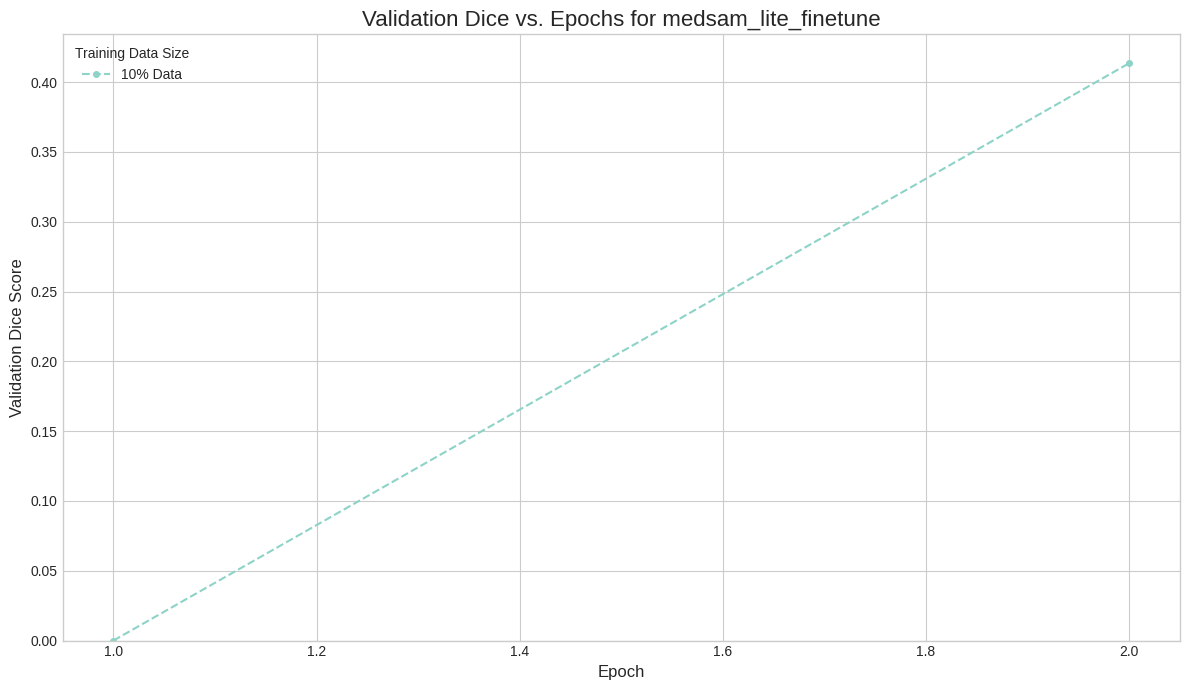

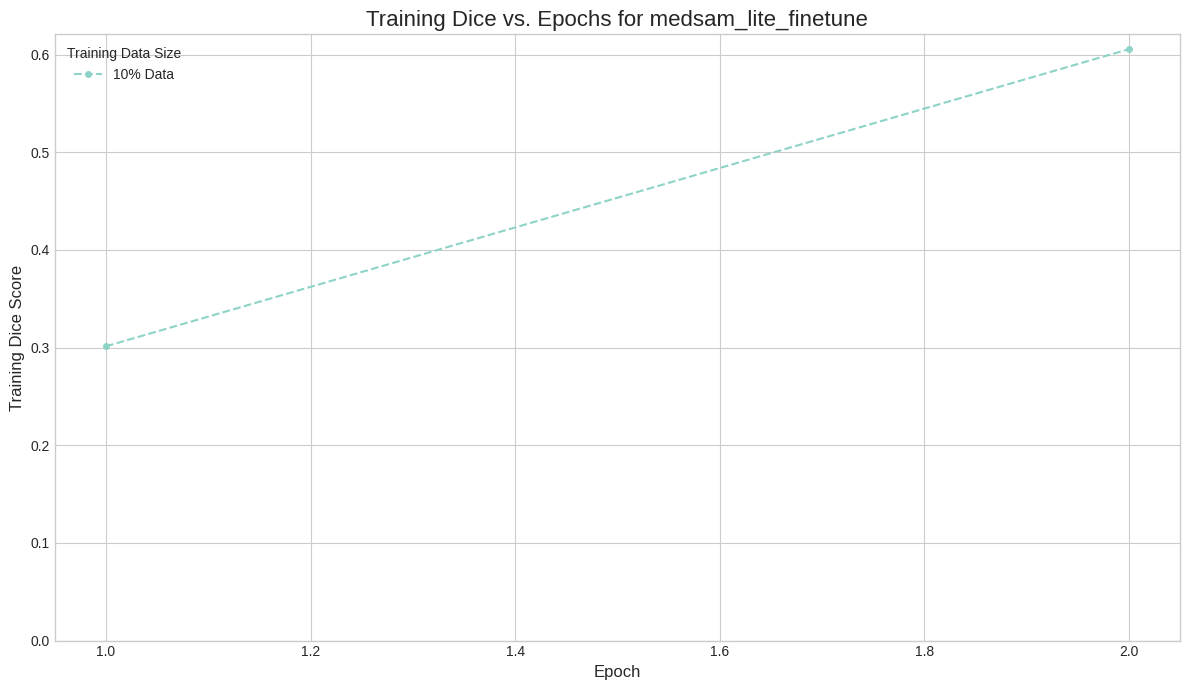

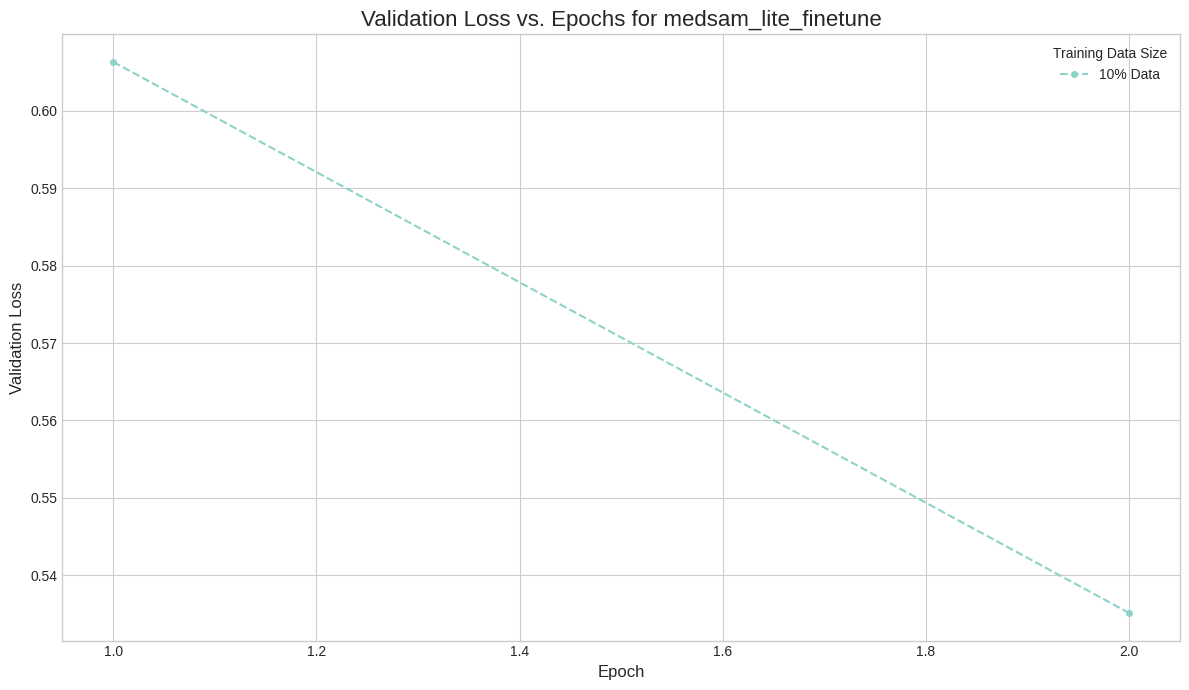

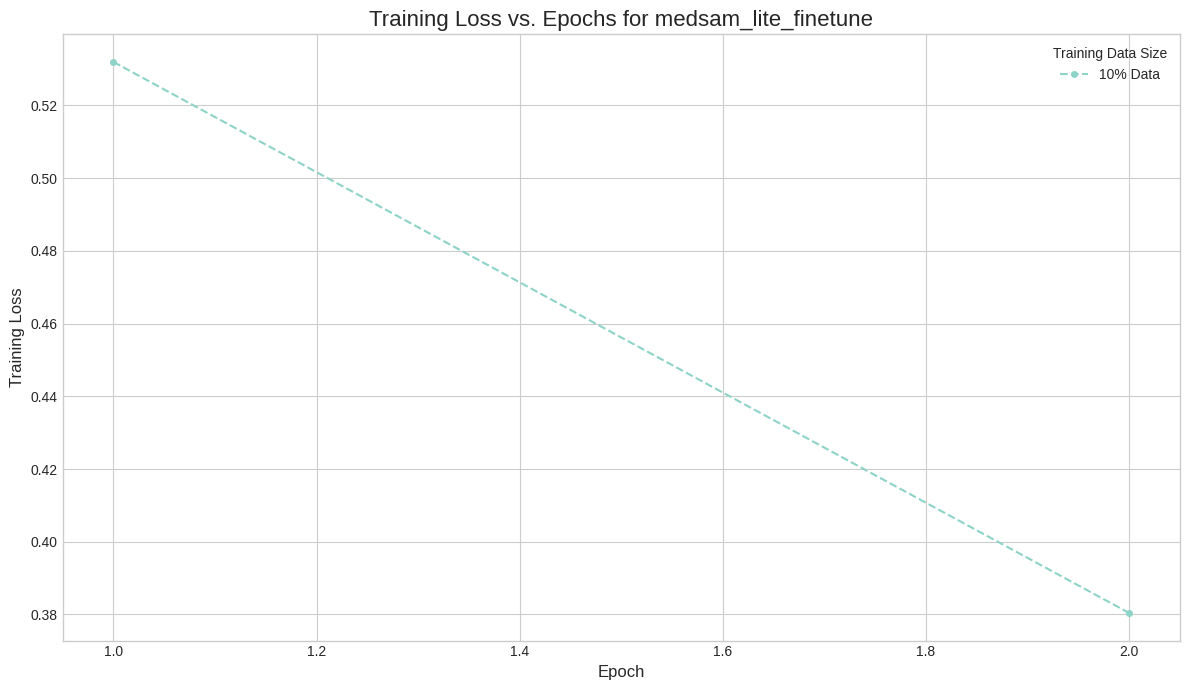

IndexError: list index out of range

In [31]:
def plot_metric_over_epochs(results, model_key, metric_key, title_name, y_label):
    """
    Generates a line plot of a given metric over epochs for different training sizes.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    
    epochs = len(next(iter(results[model_key].values()))[metric_key])
    epoch_range = range(1, epochs + 1)
    
    for percent, data in sorted(results[model_key].items()):
        ax.plot(epoch_range, data[metric_key], label=f'{percent}% Data', marker='o', markersize=4, linestyle='--')
        
    ax.set_title(f'{title_name} for {model_key}', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.legend(title='Training Data Size')
    
    # Ensure y-axis starts at 0 for non-loss plots
    if 'loss' not in metric_key:
        ax.set_ylim(bottom=0)

    plt.tight_layout()
    plt.savefig(f"./lite_medsam/results/{model_key}_{metric_key}_vs_epochs.png")
    plt.show()

def plot_best_metric_comparison(results, metric_key, title_name, y_label, mode='max'):
    """
    Generates a grouped bar plot comparing the best score (max or min) of a metric.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    model_keys = list(results.keys())
    percentages = sorted(results[model_keys[0]].keys())
    
    best_scores_model1 = [results[model_keys[0]][p][metric_key] for p in percentages]
    best_scores_model2 = [results[model_keys[1]][p][metric_key] for p in percentages]
    
    x = np.arange(len(percentages))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(14, 8))
    rects1 = ax.bar(x - width/2, best_scores_model1, width, label=model_keys[0])
    rects2 = ax.bar(x + width/2, best_scores_model2, width, label=model_keys[1])
    
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title_name, fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels([f'{p}%' for p in percentages])
    ax.set_xlabel('Training Data Percentage', fontsize=12)
    ax.legend()
    
    ax.bar_label(rects1, padding=3, fmt='%.3f')
    ax.bar_label(rects2, padding=3, fmt='%.3f')
    
    # Adjust y-limit for better visualization
    if mode == 'max':
        upper_lim = max(max(best_scores_model1), max(best_scores_model2)) * 1.1
        ax.set_ylim(top=upper_lim)
    
    plt.tight_layout()
    plt.savefig(f"./lite_medsam/results/{metric_key}_comparison.png")
    plt.show()

# --- Generate ALL the Plots ---
print("--- Generating Plots for All Metrics ---")

# Define the plots we want to create
plots_to_generate = {
    'line': [
        {'metric_key': 'val_dices', 'title_name': 'Validation Dice vs. Epochs', 'y_label': 'Validation Dice Score'},
        {'metric_key': 'train_dices', 'title_name': 'Training Dice vs. Epochs', 'y_label': 'Training Dice Score'},
        {'metric_key': 'val_losses', 'title_name': 'Validation Loss vs. Epochs', 'y_label': 'Validation Loss'},
        {'metric_key': 'train_losses', 'title_name': 'Training Loss vs. Epochs', 'y_label': 'Training Loss'},
    ],
    'bar': [
        {'metric_key': 'max_val_dice', 'title_name': 'Max Validation Dice Comparison', 'y_label': 'Max Validation Dice', 'mode': 'max'},
        {'metric_key': 'max_train_dice', 'title_name': 'Max Training Dice Comparison', 'y_label': 'Max Training Dice', 'mode': 'max'},
        {'metric_key': 'min_val_loss', 'title_name': 'Min Validation Loss Comparison', 'y_label': 'Min Validation Loss', 'mode': 'min'},
        {'metric_key': 'min_train_loss', 'title_name': 'Min Training Loss Comparison', 'y_label': 'Min Training Loss', 'mode': 'min'},
    ]
}

# Generate line plots for each model
for model_name in experiment_results.keys():
    for plot_info in plots_to_generate['line']:
        plot_metric_over_epochs(experiment_results, model_name, **plot_info)

# Generate bar plots comparing the models
for plot_info in plots_to_generate['bar']:
    plot_best_metric_comparison(experiment_results, **plot_info)